# Training a machine learning model to predict lithuanian educational olympiad results + Data analysis

# 1. Data setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier 

z:\projects\python\personal\Lithuanian olympiad result prediction using machine learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("olimpiada.csv")
data.head()

,_type,_id,_revision,_page.next,vda_prime_key,renginys,tipas,laimejimas,vardas,pavarde,mokytojai,komandos_vadovai,svietimo_istaiga,klase,vieta,metai,pilna_data
0,datasets/gov/linesa/ondb/Dalyvis,595ed70b-e4e4-4acb-b002-900cf5da23ad,a261141a-6ebd-4444-ba03-0a964edfe4c0,NaN,007e0bf4708ea6c,Lietuvos Junior Achievement Nacionalinė mokomų...,Lietuvos,I,b36564972ddb3de,3c7c4cb60355d6b,Andželika Rusteikienė,NaN,Vilniaus Gedimino technikos universiteto inžin...,II gimnazinė,Vilnius,2024,2024 m. gegužės 17 d.
1,datasets/gov/linesa/ondb/Dalyvis,8bc10f92-2478-4f7b-9171-ca029c119115,471b8d65-aa54-4cb2-b71b-16ad25e6e274,NaN,00bd4e380dfe31a,6–oji Lietuvos mokinių etninės kultūros olimpiada,Lietuvos,II,82268f800130f2a,868f173344c9c6f,"Agnė Audėjienė, Rūta Vekerotienė",NaN,Molėtų gimnazija,III gimnazinė,"Taujėnai, Ukmergės r.",2024,2024 m. balandžio 26–27 d.
2,datasets/gov/linesa/ondb/Dalyvis,4314f34b-0146-4c12-a592-ac9ca9968cd9,529c78b2-f2be-4039-8832-1e4f33c39ef3,NaN,00e756f66ef74f0,56-asis Lietuvos mokinių jaunųjų filologų konk...,Lietuvos,II,2b158e105b9f9e0,ad6c6fba4d08ef7,Egidijus Miknevičius,NaN,Panevėžio Juozo Balčikonio gimnazija,III gimnazinė,Palanga,2024,2024 m. balandžio 27–28 d.
3,datasets/gov/linesa/ondb/Dalyvis,4022e66f-6ffd-47dd-a72a-120ae55ab250,5c956c83-fd78-493b-8504-3b3bfc17ebd3,NaN,01b11644795fbdf,71-oji Lietuvos mokinių fizikos olimpiada,Lietuvos,III,9e4a052518d5c83,071f4d27465259c,Violeta Čibinskienė,NaN,Šiaulių universitetinė gimnazija,II gimnazinė,Vilnius,2024,2024 m. kovo 9–11 d.
4,datasets/gov/linesa/ondb/Dalyvis,c1d99cef-581d-4f36-b5c0-6acff329d421,4496b11b-17b1-48a4-aec9-6fdba27ed016,NaN,01b6c0636873d06,31-oji Lietuvos mokinių rusų (užsienio) kalbos...,Lietuvos,Pagyrimo raštas,8dab03a878759b4,401c969f21f88c8,Irena Veličkienė,NaN,Vilniaus r. Kalvelių „Aušros“ gimnazija,III gimnazinė,Vilnius,2024,2024 m. kovo 28 d.


# 2. Exploratory Data Analysis

In [3]:
data.dtypes

_type               object
_id                 object
_revision           object
_page.next          object
vda_prime_key       object
renginys            object
tipas               object
laimejimas          object
vardas              object
pavarde             object
mokytojai           object
komandos_vadovai    object
svietimo_istaiga    object
klase               object
vieta               object
metai                int64
pilna_data          object
dtype: object

In [4]:
data.nunique()

_type                 1
_id                 804
_revision           804
_page.next            1
vda_prime_key       804
renginys             53
tipas                 2
laimejimas           23
vardas              310
pavarde             584
mokytojai           466
komandos_vadovai     15
svietimo_istaiga    261
klase                17
vieta                26
metai                 2
pilna_data           46
dtype: int64

Dropping unhelpful columns

In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
data.drop(["_type", "_id", "_revision", "_page.next", "vda_prime_key", "vardas", "pavarde"],axis=1, inplace=True)

In [7]:
data.sample(5)

,renginys,tipas,laimejimas,mokytojai,komandos_vadovai,svietimo_istaiga,klase,vieta,metai,pilna_data
549,35-oji Lietuvos mokinių informatikos olimpiada,Lietuvos,Pagyrimo raštas,Bronius Skūpas,NaN,Vilniaus licėjus,III gimnazinė,Vilnius,2024,2024 m. kovo 1–4 d.
529,56-asis Lietuvos mokinių jaunųjų filologų konk...,Lietuvos,III,"Giedrė Arlauskienė, Aušra Šeštokienė",NaN,Palangos senoji gimnazija,III gimnazinė,Palanga,2024,2024 m. balandžio 27–28 d.
14,62-oji Lietuvos mokinių chemijos olimpiada,Lietuvos,II,Violeta Laurinaitienė,NaN,Vilniaus Gedimino technikos universiteto inžin...,II gimnazinė,Vilnius,2024,2024 m. vasario 22–24 d.
223,Lietuvos mokinių meninio skaitymo konkursas,Lietuvos,II,Gintarė Blazgienė,NaN,Marijampolės „Ryto“ pagrindinės mokykla,6,Vilnius,2024,2024 m. balandžio 13 d.
81,Lietuvos mokinių meninio skaitymo konkursas,Lietuvos,II,Algis Želvys,NaN,Panevėžio Juozo Miltinio gimnazija,III gimnazinė,Vilnius,2024,2024 m. balandžio 13 d.


In [ ]:
data.isna().sum() # check for missing values

renginys              0
tipas                 0
laimejimas           42
mokytojai             3
komandos_vadovai    715
svietimo_istaiga      0
klase                 0
vieta                 0
metai                 0
pilna_data            0
dtype: int64

In [9]:
data["laimejimas"].value_counts()

laimejimas
III                                                                                                                            218
II                                                                                                                             175
Pagyrimo raštas                                                                                                                170
I                                                                                                                              125
Bronzos medalis                                                                                                                 13
II, laureatas                                                                                                                   11
Sidabro medalis                                                                                                                 10
I, laureatas                                                            

# 3. Feature Engineering

mapping the target column 'laimejimas' to only include 3 places I, II and III

In [10]:
data["laimejimas"].unique()

array(['I', 'II', 'III', 'Pagyrimo raštas', 'Sidabro medalis',
       'sidabro medalis', 'aukso medalis', 'II, laureatas',
       'Aukso medalis', nan, 'I, laureatas', 'bronzos medalis',
       'Bronzos medalis', 'III vieta', 'III, laureatas', 'I vieta',
       'I , laureatas', 'J. Baranovos vardo dipl.',
       'Aukso medalis, specialusis prizas už II kategorijos geriausią originalią kompoziciją.',
       'Grand Prix', 'II, publikos simpatijos', 'Bronzo medalis',
       'II vieta',
       'Aukso medalis, specialieji prizai už geriausią I kategorijos originalią kompoziciją bei skaitymo iš lapo užduoties atlikimą'],
      dtype=object)

In [11]:
mapping = { 'I': 0, 'I vieta': 0, 'I, laureatas': 0, 'I , laureatas': 0, 'aukso medalis': 0, 'Aukso medalis': 0, 'Aukso medalis, specialusis prizas už II kategorijos geriausią originalią kompoziciją.': 0, 'Aukso medalis, specialieji prizai už geriausią I kategorijos originalią kompoziciją bei skaitymo iš lapo užduoties atlikimą': 0, 'Grand Prix': np.nan, 'II': 1, 'II vieta': 1, 'II, laureatas': 1, 'II, publikos simpatijos': 2, 'Sidabro medalis': 1, 'sidabro medalis': 1, 'III': 2, 'III vieta': 2, 'III, laureatas': 2, 'bronzos medalis': 2, 'Bronzos medalis': 2, 'Bronzo medalis': 2, 'Pagyrimo raštas': np.nan, 'J. Baranovos vardo dipl.': np.nan }

In [12]:
data['laimejimas'] = data['laimejimas'].map(mapping)
data.head(3)

,renginys,tipas,laimejimas,mokytojai,komandos_vadovai,svietimo_istaiga,klase,vieta,metai,pilna_data
0,Lietuvos Junior Achievement Nacionalinė mokomų...,Lietuvos,0.0,Andželika Rusteikienė,NaN,Vilniaus Gedimino technikos universiteto inžin...,II gimnazinė,Vilnius,2024,2024 m. gegužės 17 d.
1,6–oji Lietuvos mokinių etninės kultūros olimpiada,Lietuvos,1.0,"Agnė Audėjienė, Rūta Vekerotienė",NaN,Molėtų gimnazija,III gimnazinė,"Taujėnai, Ukmergės r.",2024,2024 m. balandžio 26–27 d.
2,56-asis Lietuvos mokinių jaunųjų filologų konk...,Lietuvos,1.0,Egidijus Miknevičius,NaN,Panevėžio Juozo Balčikonio gimnazija,III gimnazinė,Palanga,2024,2024 m. balandžio 27–28 d.


Text(0, 0.5, 'Švietimo įstaiga')

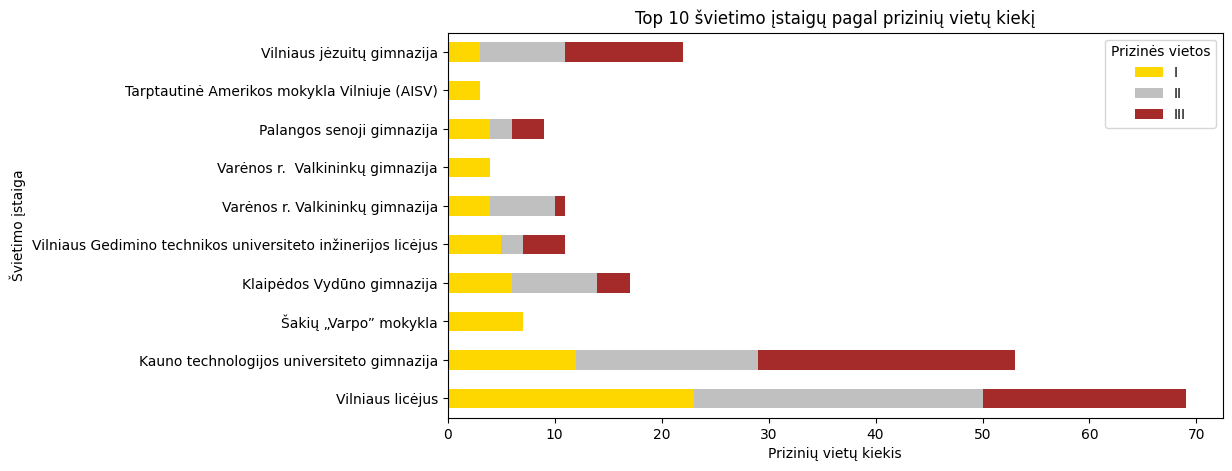

In [13]:
data.groupby('svietimo_istaiga')['laimejimas'].value_counts().unstack().sort_values(by=0, ascending=False).head(10).plot(kind='barh', stacked=True, figsize=(10, 5), color=['gold', 'silver', 'brown'])

plt.legend(title='Prizinės vietos' , labels=['I', 'II', 'III'])
plt.xlabel('Prizinių vietų kiekis')
plt.title('Top 10 švietimo įstaigų pagal prizinių vietų kiekį')
plt.ylabel('Švietimo įstaiga')

Text(0, 0.5, 'Mokytojas')

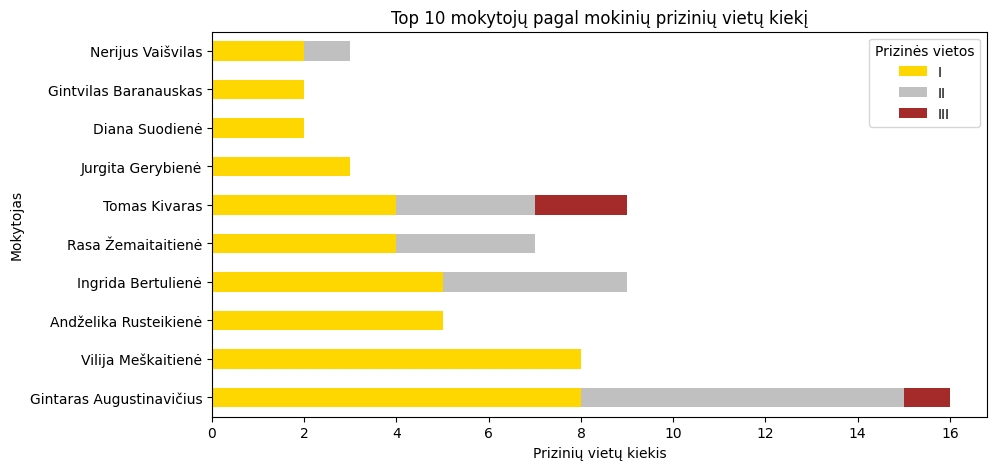

In [14]:
data.groupby('mokytojai')['laimejimas'].value_counts().unstack().sort_values(by=0, ascending=False).head(10).plot(kind='barh', stacked=True, figsize=(10, 5), color=['gold', 'silver', 'brown'])

plt.legend(title='Prizinės vietos' , labels=['I', 'II', 'III'])
plt.xlabel('Prizinių vietų kiekis')
plt.title('Top 10 mokytojų pagal mokinių prizinių vietų kiekį')
plt.ylabel('Mokytojas')

In [15]:
data.laimejimas.value_counts()

laimejimas
2.0    244
1.0    201
0.0    145
Name: count, dtype: int64

Missing 'mokytojai' values are replaced with 'Be mokytojo'

In [16]:
data.loc[data["mokytojai"].isna(), "mokytojai"] = "Be mokytojo"

80% of 'komandos_vadovai' values are missing, so lets replace the columns with the amount of team leaders for each row with most rows being 0.

In [17]:
data["komandos_vadovai"].fillna(0)

0                        0
1                        0
2                        0
3                        0
4                        0
              ...         
799                      0
800                      0
801    Danutė Stankaitienė
802                      0
803                      0
Name: komandos_vadovai, Length: 804, dtype: object

In [18]:
vadovu_skc = []
for val in data["komandos_vadovai"]:
    if val == 0:
        vadovu_skc.append(0)
    else:
        splits = str(val).split(sep=",")
        vadovu_skc.append(len(splits))

vadovu_skc[:2]

[1, 1]

In [19]:
data["komandos_vadovai"] = vadovu_skc
data.head(3)

,renginys,tipas,laimejimas,mokytojai,komandos_vadovai,svietimo_istaiga,klase,vieta,metai,pilna_data
0,Lietuvos Junior Achievement Nacionalinė mokomų...,Lietuvos,0.0,Andželika Rusteikienė,1,Vilniaus Gedimino technikos universiteto inžin...,II gimnazinė,Vilnius,2024,2024 m. gegužės 17 d.
1,6–oji Lietuvos mokinių etninės kultūros olimpiada,Lietuvos,1.0,"Agnė Audėjienė, Rūta Vekerotienė",1,Molėtų gimnazija,III gimnazinė,"Taujėnai, Ukmergės r.",2024,2024 m. balandžio 26–27 d.
2,56-asis Lietuvos mokinių jaunųjų filologų konk...,Lietuvos,1.0,Egidijus Miknevičius,1,Panevėžio Juozo Balčikonio gimnazija,III gimnazinė,Palanga,2024,2024 m. balandžio 27–28 d.


In [20]:
data.isna().sum()

renginys              0
tipas                 0
laimejimas          214
mokytojai             0
komandos_vadovai      0
svietimo_istaiga      0
klase                 0
vieta                 0
metai                 0
pilna_data            0
dtype: int64

Dropping date columns as I don't want to use them as a predictor

In [21]:
data.drop(["pilna_data", "metai"], axis=1, inplace=True)

In [22]:
data.dropna(inplace=True)
len(data)

590

In [23]:
data["klase"].unique()

array(['II gimnazinė', 'III gimnazinė', 'I gimnazinė', 'IV gimnazinė',
       '6–8', '7', '8', 'III–IV gimnazinė', '6', 'I–IV gimnazinė',
       '8 klasė', '3', '10', '5–6', '4', '5', '9'], dtype=object)

There are too many values in this categorical feature and we can turn it into numerical by mapping most values to a certain number

In [24]:
class_dict = { 'II gimnazinė': 10, 'III gimnazinė': 11, 'I gimnazinė': 9, 'IV gimnazinė': 12, '6–8': 8, '7': 7, '8': 8, 'III–IV gimnazinė': 12, '6': 6, 'I–IV gimnazinė': 12, '8 klasė': 8, '3': 3, '10': 10, '5–6': 6, '4': 4, '5': 5, '9': 9}

data['klase'] = data['klase'].map(class_dict)
data.head(3)

,renginys,tipas,laimejimas,mokytojai,komandos_vadovai,svietimo_istaiga,klase,vieta
0,Lietuvos Junior Achievement Nacionalinė mokomų...,Lietuvos,0.0,Andželika Rusteikienė,1,Vilniaus Gedimino technikos universiteto inžin...,10,Vilnius
1,6–oji Lietuvos mokinių etninės kultūros olimpiada,Lietuvos,1.0,"Agnė Audėjienė, Rūta Vekerotienė",1,Molėtų gimnazija,11,"Taujėnai, Ukmergės r."
2,56-asis Lietuvos mokinių jaunųjų filologų konk...,Lietuvos,1.0,Egidijus Miknevičius,1,Panevėžio Juozo Balčikonio gimnazija,11,Palanga


Encoding the categorical feature 'tipas' into numerical

In [25]:
tipas_mapping = {'Lietuvos': 0,
                 'Tarptautinis': 1}

data["tipas"] = data["tipas"].map(tipas_mapping)

In [26]:
data.nunique()

renginys             49
tipas                 2
laimejimas            3
mokytojai           376
komandos_vadovai      3
svietimo_istaiga    215
klase                10
vieta                22
dtype: int64

Setting up train/test splits

In [27]:
from sklearn.model_selection import train_test_split

X, y = data.drop("laimejimas", axis=1), data["laimejimas"]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Target encoding was chosen for these features because they are not ordinal, and have way too many distinct values to be one-hot-encoded, especially seeing how we only have 600 rows in our dataset

In [28]:
target_cols = ["renginys", "mokytojai", "svietimo_istaiga", "vieta"]

from category_encoders import TargetEncoder

te = TargetEncoder(cols=target_cols)
X_train[target_cols] = te.fit_transform(X_train[target_cols], y_train)
X_test[target_cols] = te.transform(X_test[target_cols])

X[target_cols] = te.fit_transform(X[target_cols], y)


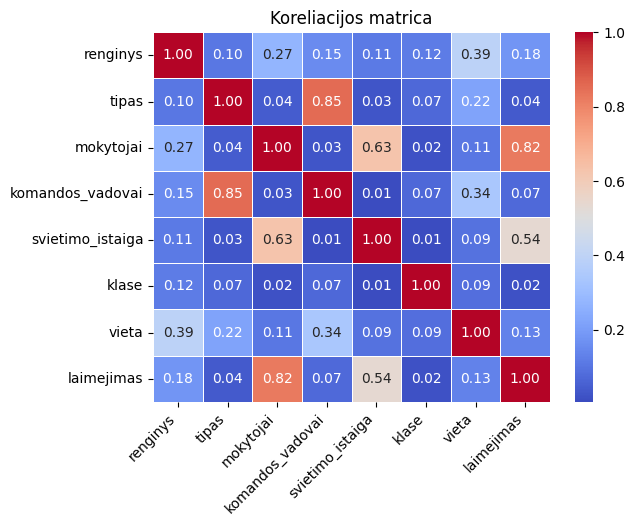

In [29]:
# concat X and y
corr_df = pd.concat([X, y], axis=1)

sns.heatmap(abs(corr_df.corr()), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Koreliacijos matrica")
plt.xticks(rotation=45, ha='right')
plt.show()

Scaling our features before feeding to a model, although it's unnecessary since the model we use is XGBoostClassifier which is an ensemble of decision trees which don't get affected by the features varying scales, although it's still good practice

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_proc = scaler.fit_transform(X_train)
X_test_proc = scaler.transform(X_test)
X_proc = scaler.fit_transform(X)

# 4. Modelling

Let's train a baseline model to compare our final model score to:

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

dummy_clf = DummyClassifier(strategy='most_frequent')

scores = cross_val_score(dummy_clf, X_proc, y, cv=5, scoring='accuracy')

print(f'Mean cross-validation score: {scores.mean()}')

Mean cross-validation score: 0.4135593220338983


Initial cross validated score is looking good: 77% accuracy

In [32]:
from xgboost import XGBClassifier
import sklearn

xgb_model = XGBClassifier()

cv_scores = cross_val_score(xgb_model, X_proc, y, cv=5)

print(cv_scores.mean())

0.7728813559322034


Unfortunately, when we dont use cross validation the score is really bad, although my theory is that there is way too little data ~600 rows, and taking away 20% for a test split affects it really badly

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

xgb_model = XGBClassifier()
xgb_model.fit(X_train_proc, y_train)

y_preds = xgb_model.predict(X_test_proc)

print(accuracy_score(y_test, y_preds))

0.4152542372881356


In [34]:
X_trainval_proc = X_train_proc
y_trainval = y_train

Creating a validation split for hyperparameter tuning

In [35]:
X_train_proc, X_val_proc, y_train, y_val = train_test_split(X_trainval_proc, y_trainval, test_size=0.2, random_state=42)

Using optuna to search for the best parameters

In [36]:
import optuna
from xgboost import XGBClassifier
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):

    param_grid = {
        'objective': 'multi:softmax',
        'learning_rate': 0.3,
        'tree_method':  trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'n_estimators': 100000,
        'early_stopping_rounds': 25
    }

    clf = XGBClassifier(**param_grid)
    clf.fit(X_train_proc, y_train, eval_set=[(X_val_proc, y_val)], verbose=0)
    y_pred = clf.predict(X_val_proc)

    acc = accuracy_score(y_val, y_pred)
    return acc

The search goes on for 300 seconds

In [38]:
import time


study = optuna.create_study(direction='maximize')

tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

These are the resulting best parameters

In [39]:
study.best_params

{'tree_method': 'approx',
 'max_depth': 7,
 'min_child_weight': 22,
 'subsample': 0.4090840375886399,
 'reg_lambda': 1.0587858532313816}

Now that we have the ideal tree parameters which we found relatively quickly due to a high learning rate, now we set the learning rate very low and use early stopping to find the best amount n_estimators for our model

In [40]:
new_params = {'tree_method': 'approx',
 'max_depth': 10,
 'min_child_weight': 37,
 'subsample': 0.8949926313039528,
 'reg_lambda': 0.04499990751947653,
 'learning_rate': 0.01,
 'n_estimators': 100000,
 'early_stopping_rounds': 25}

xgb_early = XGBClassifier(**new_params)

xgb_early.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=25,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=37, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

We found that the best amount n_estimators for the model is equal to 2183, so let's update our parameter dictionary and train our final model with cross validation

In [41]:
xgb_early.best_iteration

2183

It seems like we managed to make our model better by around ~3% after tuning

In [42]:
final_params = {'tree_method': 'approx',
 'max_depth': 8,
 'min_child_weight': 25,
 'subsample': 0.6300046316517319,
 'reg_lambda': 0.12225427111713684,
 'learning_rate': 0.01,
 'n_estimators': 2183}

xgb_final = XGBClassifier(**final_params)

scores = cross_val_score(xgb_final, X_proc, y, cv=10)

print(f"Final Accuracy: {scores.mean()*100:.2f}%")

Final Accuracy: 80.34%


# 5. Results And Conclusion

The final score for our model is 80.34%. Not bad considering the small dataset. Even though this model has little practical use, it's still good practice. Now if you knew some things about a competitor like the name of their teacher or the name of their school or their school year you could guess their placement with 80% accuracy, although there are still many caveats.